In [1]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [2]:
%%bash
cd .. && make clean && make

In file included from src/Exercice5_students.cpp:7:
src/ConfigFile.tpp:67:8: warning: variable 'out' is used uninitialized whenever 'if' condition is false [-Wsometimes-uninitialized]
  if ( val != configMap.end() ) {
       ^~~~~~~~~~~~~~~~~~~~~~
src/Exercice5_students.cpp:163:33: note: in instantiation of function template specialization 'ConfigFile::get<double>' requested here
        const double tfin = configFile.get<double>("tfin");
                                       ^
src/ConfigFile.tpp:74:10: note: uninitialized use occurs here
  return out;
         ^~~
src/ConfigFile.tpp:67:3: note: remove the 'if' if its condition is always true
  if ( val != configMap.end() ) {
  ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
src/ConfigFile.tpp:66:8: note: initialize the variable 'out' to silence this warning
  T out;
       ^
        = 0.0
src/ConfigFile.tpp:67:8: warning: variable 'out' is used uninitialized whenever 'if' condition is false [-Wsometimes-uninitialized]
  if ( val != configMap.end() ) 

In [3]:
config_name = 'bassinmode'
conf = load_conf(config_name)

g = 9.81

A = conf['A']
xL = conf['xL']
xR = conf['xR']
h00 = conf['h00']

In [4]:

n = 2
tfin = 4 * (conf['xR']-conf['xL']) / ( (2*n +1) * np.sqrt(conf['h00']*g) )
original_nx = 20
original_nsteps = 4/(2*n+1)

factors = 2**np.arange(0, 9, 1)
print(factors)

nx = original_nx * factors
print(nx)
# nsteps = original_nsteps * factors

# params, data_x, data_v, data_f
dataset = run_with_params(
    config_name,
    # [{}]
    gen_variations({
        # 'initial_state': ['left', 'right', 'static'],
        'tfin': [tfin],
        'n_init': [n],
        'nx': nx,
        # 'impose_nsteps': ['true'],
        # 'nsteps': nsteps,
    })
)

[  1   2   4   8  16  32  64 128 256]
[  20   40   80  160  320  640 1280 2560 5120]
Running simulations... Done 4/9

[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "[ConfigFile] Ligne sans '=' : "# Physique :"
# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"


Running simulations... Done 9/9


# plots AND ANIMATIONS!

In [5]:
def analytique_sol(x ,t=tfin):
    # A in the code is the 2A of the theory
    return 2 * A * np.sin(np.pi * (2*n + 1) * (x - xL) / (2*(xR - xL))) \
            * np.cos(np.pi * (2*n + 1) * np.sqrt(g * h00) * t / (2*(xR - xL)))

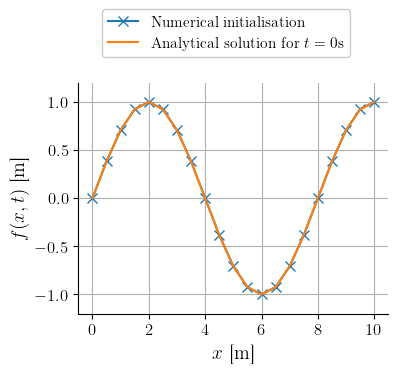

In [14]:
%matplotlib inline

params, x, v, f, _ = dataset[0]

plt.plot(x, f[0,1:], 'x-', markersize=7, label="Numerical initialisation")
plt.plot(x, analytique_sol(x, 0), label=r"Analytical solution for $t=0$s")
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$f(x,t)$ [m]')
plt.ylim(-1.2, 1.2)
plt.grid()
plt.legend(bbox_to_anchor=(0.9,1.35))
plt.savefig(export_path + 'bassin_mode_start.pdf')

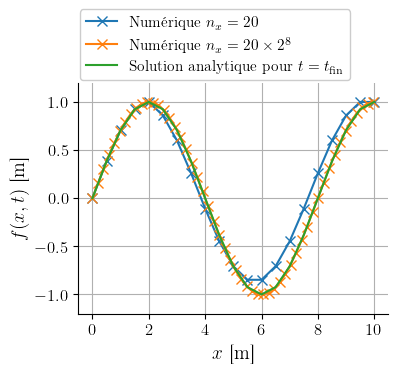

In [7]:
%matplotlib inline

params_0, x_0, v_0, f_0, _ = dataset[0]
params_g, x_g, v_g, f_g, _ = dataset[-1]


plt.plot(x_0, f_0[-1,1:], 'x-', markersize=7, label=r"Numérique $n_x = 20$")

cache = range(0, len(x_g), 100)
plt.plot(x_g[cache], f_g[-1,1:][cache], 'x-', markersize=7, label=r"Numérique $n_x = 20 \times 2^8$")
plt.plot(x_0, analytique_sol(x_0, tfin), label=r"Solution analytique pour $t=t_\mathrm{fin}$")
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$f(x,t)$ [m]')
plt.ylim(-1.2, 1.2)
plt.grid()
plt.legend(bbox_to_anchor=(0.9,1.35))
plt.savefig(export_path + 'bassin_mode_end.pdf')

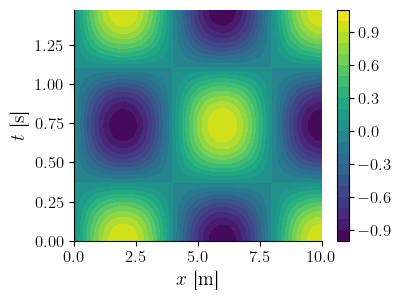

In [8]:
%matplotlib inline

params, x, v, f, h0 = dataset[-1]
t = f[:,0]
h = f[:,1:]
X, Y = np.meshgrid(x, t)
plt.contourf(X, Y, h, levels=20, cmap=plt.get_cmap('viridis'))
plt.colorbar()
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$t$ [s]')

plt.savefig(export_path + 'bassin_mode_level.png')

In [9]:
# import matplotlib.animation as mpla

# %matplotlib qt

# # 0 for left, 1 for right, 2 for static
# selected = 0

# params, x, v, f, _ = dataset[selected]

# plt.figure(figsize=(8, 8))

# line, = plt.plot(x, f[0,1:], 'x-', markersize=5)
# size = f.shape[0]

# def animate(i) -> Any:
#     idx = i % size
#     line.set_data(x, f[idx,1:])

# anim = mpla.FuncAnimation(plt.gcf(), animate, interval=20, cache_frame_data=True, frames=size)

# plt.xlabel(r'$x$ [m]')
# plt.ylabel(r'$y$ [m]')
# plt.ylim(-2, 2)
# plt.grid()

# Plots convergence

In [10]:
def erreur(x, data_f, dx):
    return np.sum(np.abs(data_f - analytique_sol(x, tfin))*dx)

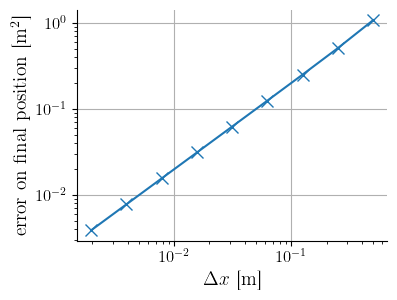

In [13]:

dx = (xR - xL) / (nx)
erreurs = []
for i, datas in enumerate(dataset):
    erreurs.append(erreur(datas[1], datas[3][-1][1:], dx[i]))
plt.loglog(dx, erreurs, 'x-')
plt.xlabel(r"$\Delta x$ [m]")
plt.ylabel(r"error on final position [m$^2$]")

plt.grid()
plt.savefig(export_path + 'bassin_mode_convergence.pdf')